In [15]:
# basic libs
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns 

# text processing
import string
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
STOPWORDS = set(stopwords.words('english'))
from collections import Counter

# Topic Modelling
import gensim
import gensim.corpora as corpora
import spacy
import pyLDAvis.gensim_models 

/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
import pyLDAvis.gensim_models

# EDA

### Load data

In [6]:
def load_data(filepath):
    """Load dataframe. """
    
    # some rows malformed in raw dataset - drop
    df = pd.read_csv(filepath).dropna()
    
    df.drop(columns=df.columns[0], axis=1, inplace=True)
    df.drop(columns='parse_count', axis=1, inplace=True)
    
    # enforce dtypes
    df.date = pd.to_datetime(df.date)
    dtypes = {'restaurant_name':'string',
              'rating_review':float,
              'sample':'string',
              'review_id':'string',
              'title_review':'string',
              'review_preview':'string',
              'review_full':'string',
              'city':'string',
              'url_restaurant':'string',
              'author_id':'string'}
    
    df = df.astype(dtypes)
    
    # Some duplicates in our dataset - enforce unique by review_id
    df = df.drop_duplicates(subset=['review_id'])
    
    return df

df = load_data('data/London_reviews.csv');

/var/folders/k7/rw_71rkn0dd1jwkscbzbdf_w0000gn/T/ipykernel_9640/2905960960.py:5: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath).dropna()


In [7]:
# Take a peek
df.head()

,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,Cocotte_Notting_Hill,5.0,Positive,review_771556136,JUST PERFECT,"I was away for couple of months and I am so happy to be back for my regular cocotte meal, after collecting from the restaurant everything was as great and perfect than eating in. Juicy chicken, fresh side, amazing mash potato.What a great dinner at...","I was away for couple of months and I am so happy to be back for my regular cocotte meal, after collecting from the restaurant everything was as great and perfect than eating in. Juicy chicken, fresh side, amazing mash potato.What a great dinner at home again thanks to COCOTTE.",2020-09-23,London_England,https://www.tripadvisor.com/Restaurant_Review-g186338-d9994333-Reviews-Cocotte_Notting_Hill-London_England.html,UID_0
1,Cocotte_Notting_Hill,5.0,Positive,review_771555883,"Quality food, Food travels well, Excellent customer service","I recently ordered over the phone from Cocotte to collect for a gathering at home. On calling the restaurant for the delivery, the service was polite, well communicated and friendly. The person on the phone had a great knowledge of the menu and gave helpful...","I recently ordered over the phone from Cocotte to collect for a gathering at home. On calling the restaurant for the delivery, the service was polite, well communicated and friendly. The person on the phone had a great knowledge of the menu and gave helpful suggestions for customer favourites. The food was ready to collect swiftly at the time we requested and was well packaged for the journey home. The food itself traveled well which is fantastic, the food remained warm and as tasty as when we've eaten on site. All in all what a fabulous night made perfect by Cocottes tasty food and efficient service.",2020-09-23,London_England,https://www.tripadvisor.com/Restaurant_Review-g186338-d9994333-Reviews-Cocotte_Notting_Hill-London_England.html,UID_1
2,Cocotte_Notting_Hill,5.0,Positive,review_770716943,Came here because we missed,"Came here because we missed our table at Farmacy across the road. The waitress accommodated us within 10 minutes and offered suitable vegan food. No lager on tap but not the end of the world. Enjoyed everything. 2 people, 4 dishes, 2 cocktails and 2...","Came here because we missed our table at Farmacy across the road. The waitress accommodated us within 10 minutes and offered suitable vegan food. No lager on tap but not the end of the world. Enjoyed everything. 2 people, 4 dishes, 2 cocktails and 2 beers came to £62 which seemed reasonable for this area in London. Would certainly come back for a snack.",2020-09-17,London_England,https://www.tripadvisor.com/Restaurant_Review-g186338-d9994333-Reviews-Cocotte_Notting_Hill-London_England.html,UID_2
3,Cocotte_Notting_Hill,5.0,Positive,review_770027676,Great service,"My first time in cocotte and was amazed by how friendly this member of front of house staff Julia was. From I entered, during our meal and until we left. My partner was left delighted at how attentive she was and we will definitely come...","My first time in cocotte and was amazed by how friendly this member of front of house staff Julia was. From I entered, during our meal and until we left. My partner was left delighted at how attentive she was and we will definitely come back again",2020-09-12,London_England,https://www.tripadvisor.com/Restaurant_Review-g186338-d9994333-Reviews-Cocotte_Notting_Hill-London_England.html,UID_3
4,Cocotte_Notting_Hill,5.0,Positive,review_766307138,𝓔𝔁𝓬𝓮𝓵𝓵𝓮𝓷𝓽 𝓕𝓪𝓻𝓶-𝓽𝓸-𝓣𝓪𝓫𝓵𝓮 𝓡𝓸𝓽𝓲𝓼𝓼𝓮𝓻𝓲𝓮,"A healthy-homemade dishes using farm-grown ingredients 👍🏻 Really lovely ambience, chic, intimate, and romantic! ❤️ Just perfect with such a friendly service and of course delicious menu! 🤤 Swipe to see the outstanding dessert! 😉 #dinewithmalachi recommendＣＨＥＥＫＹ ＬＵＮＣＨA Quarter Free Range ChickenSourced...","A healthy-homemade dishes using farm-grown ingredients Really

### Some basic stats about our dataset.

In [8]:
def get_basic_stats(df):
    print("Number of reviews: ", len(df))
    print("Number of unique reviewers: ", len(df.author_id.unique()))
    print("Number of restaurants reviewed: ", len(df.restaurant_name.unique()))
    
get_basic_stats(df)

Number of reviews:  996544
Number of unique reviewers:  502226
Number of restaurants reviewed:  1827


### How long is the average review?

Average number of words in a review:  85.51264269314751


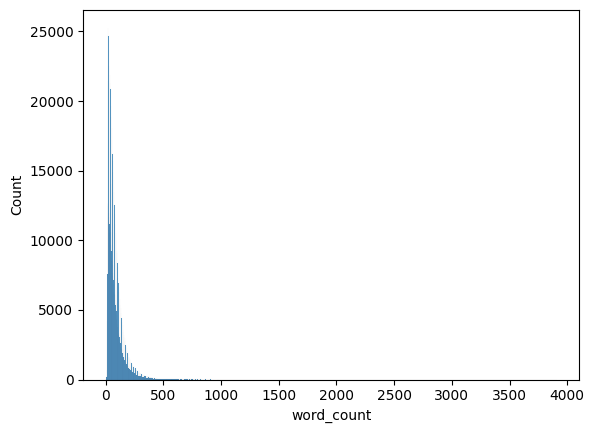

In [9]:
def get_word_count(text):
    return len(text.split())

df['word_count'] = df.review_full.apply(get_word_count)
print("Average number of words in a review: ", df.word_count.mean())
plt.figure(dpi=100)
ax = sns.histplot(df.word_count)

The distribution of word counts is heavily right-skewed. On average, there are 85 words in the body of a review. This information may be useful later in preprocessing, e.g. truncating longer reviews to fit transformer input limits.

## Reviews

### What proportion of reviews are negative/positive?

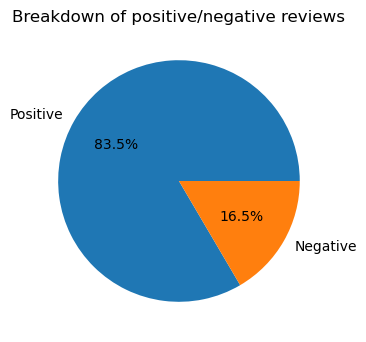

In [127]:
plt.figure(dpi=100)
ax = df['sample'].value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.set_ylabel('');
ax.set_title('Breakdown of positive/negative reviews');

The sample label appears to categorise all reviews <=3 as negative, and all reviews >3 as positive. 

Under this labelling, the majority of reviews are positive.

### What are the top unigrams/bigrams for positive and negative reviews?

In [2]:
def tokenize(text):
    # conver to lowercase
    text = text.lower()
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # convert to list of words
    text = text.split()
    
    return text
    

def get_ngrams(text, n=1):
    
    text = tokenize(text)
    ngram_list = list(ngrams(text, n))
    
    # remove stopwords if present at start or end of sentence
    clean_ngram_list = []
    for i, ngram in enumerate(ngram_list):
        if ngram[0] not in STOPWORDS and ngram[-1] not in STOPWORDS:
            clean_ngram_list.append('_'.join([word for word in ngram]))
            
    return clean_ngram_list

In [350]:
tqdm.pandas()
df['unigrams'] = df.review_full.progress_apply(get_ngrams, n=1)
df['bigrams'] = df.review_full.progress_apply(get_ngrams, n=2)
df['trigrams'] = df.review_full.progress_apply(get_ngrams, n=3)

100%|████████████████████████████████████████████████████████████████████████| 996544/996544 [03:17<00:00, 5054.73it/s]


#### Top unigrams/bigrams for positive reviews

In [351]:
def compare_ngrams(ngram='bigrams'):
    
    # count ngrams
    positive_ngrams = df[df['sample']=='Positive'][ngram].explode().value_counts().head(15) 
    negative_ngrams = df[df['sample']=='Negative'][ngram].explode().value_counts().head(15) 
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(30, 12))
    sns.barplot(data=positive_ngrams.reset_index(), y='index', x=ngram, ax=ax[0])
    ax[0].set_title('Positive Reviews');
    ax[0].tick_params(labelsize=14)
    sns.barplot(data=negative_ngrams.reset_index(), y='index', x=ngram, ax=ax[1])
    ax[1].set_title('Negative reviews')
    ax[1].tick_params(labelsize=14)
    fig.suptitle('Top ' + ngram, fontsize=28);

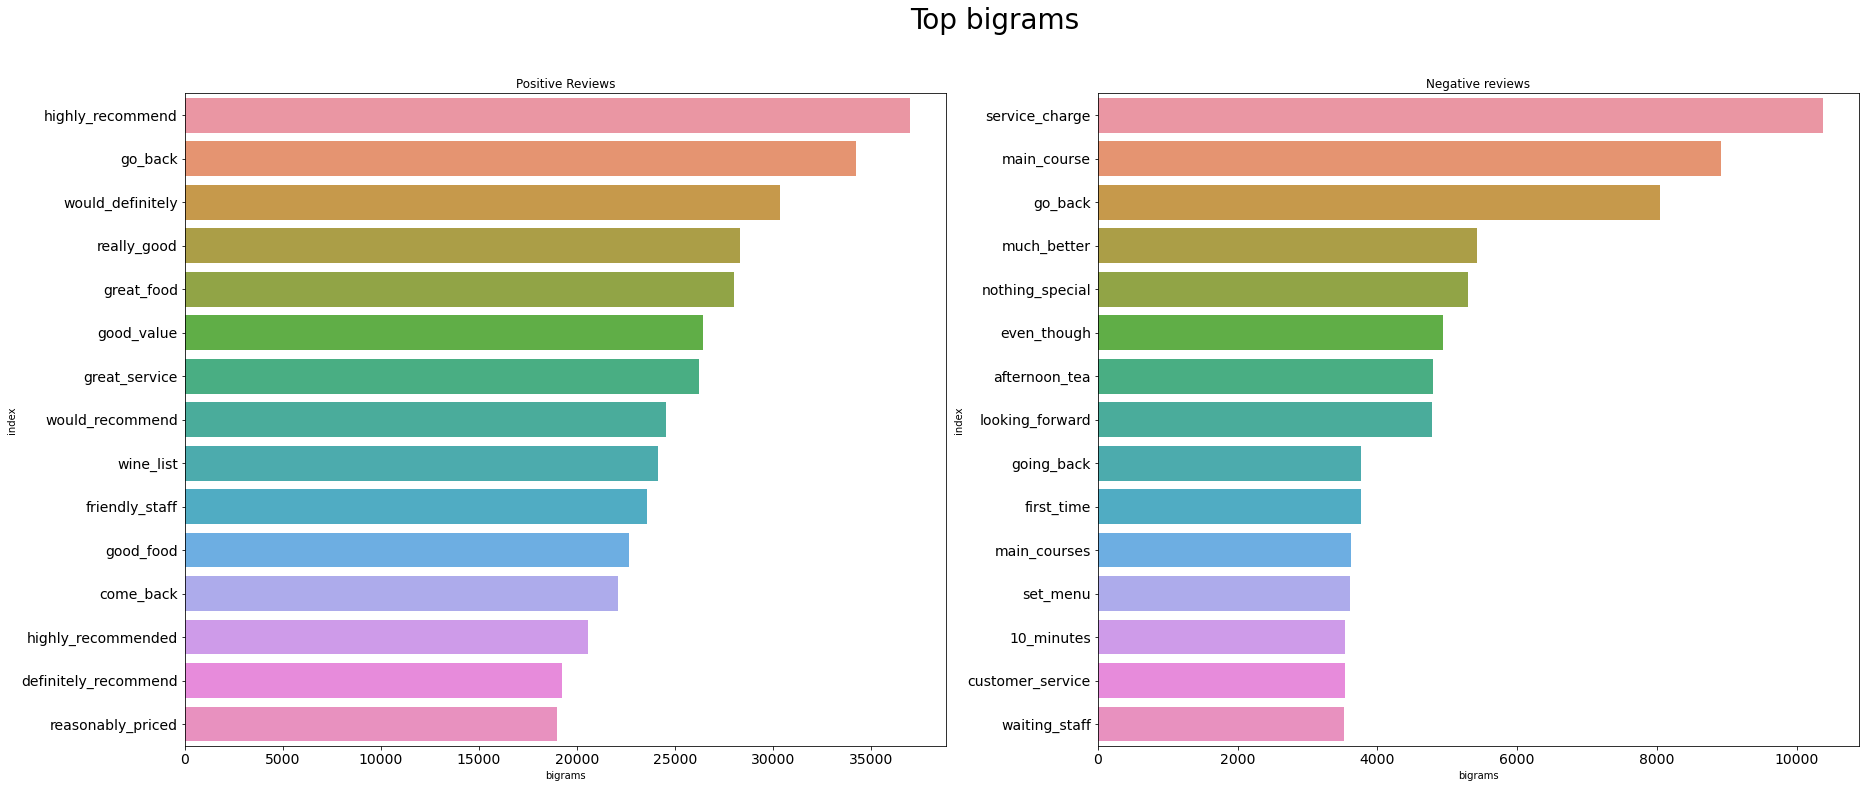

In [352]:
compare_ngrams('bigrams')

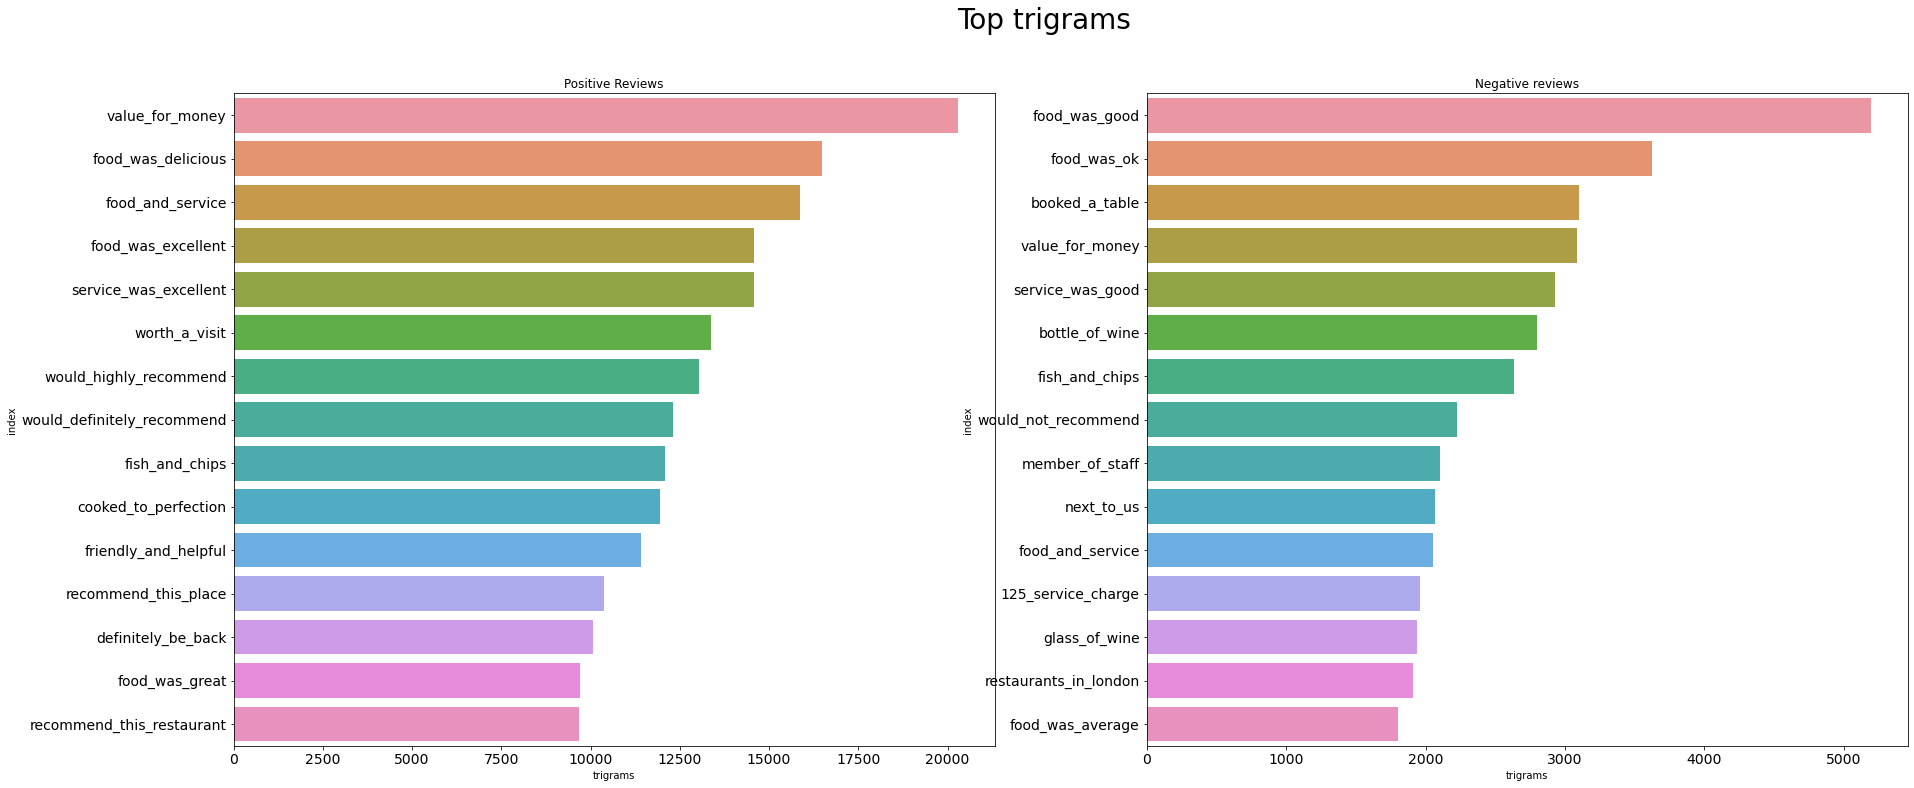

In [353]:
compare_ngrams('trigrams')

Trigrams are particularly informative in this instance. For positive reviews, important factors such as value for money, good food quality, and good service quality appear to feature heavily. For negative reviews, we observe that terms relating to food quality (food_was_ok, food_was_average), value for money (value_for_money), and service (food_and_service, 125_service_charge) in particular dominate discussion.  

### Positive/Negative Topic Modelling

In [37]:
def remove_stopwords(text):
    return [word for word in text if word not in STOPWORDS]

def lda_preprocess(text):
    text = tokenize(text)
    text = remove_stopwords(text)
    return text

def get_lda_model(sample='Positive', num_topics=5):
    tqdm.pandas()
    text_data = df[df['sample']==sample].review_full.progress_apply(lda_preprocess).values
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in tqdm(text_data)]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary)
    
    return ldamodel

In [38]:
positive_lda_model = get_lda_model('Positive', num_topics=5)
negative_lda_model = get_lda_model('Negative', num_topics=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831684/831684 [05:03<00:00, 2744.43it/s]


In [39]:
def display_lda_model(lda_model):
    lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)
    

In [40]:
display_lda_model(positive_lda_model)

/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated

In [41]:
display_lda_model(negative_lda_model)

/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/leon/miniconda3/envs/cwt/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated

## Ratings

### How are the ratings distributed?

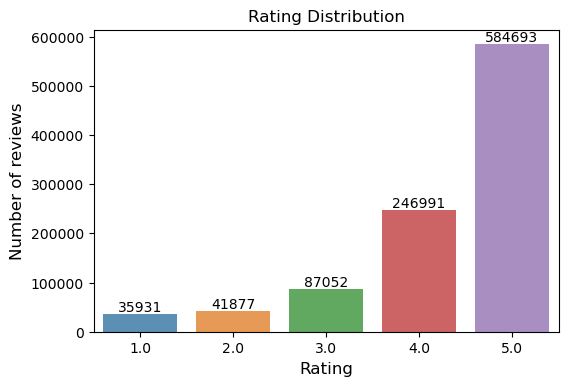

In [128]:
#Get the distribution of the ratings
rating_counts = df.rating_review.value_counts()
rating_counts = rating_counts.sort_index()

#plot
plt.figure(dpi=100)
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, alpha=0.8)
plt.title("Rating Distribution")
plt.ylabel('Number of reviews', fontsize=12)
plt.xlabel('Rating', fontsize=12)

#adding the text labels
rects = ax.patches
labels = rating_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


Further breaking down the positive/negative reviews, we can see that the distribution of ratings is highly skewed towards 5-stars. 
Perhaps the general quality of London restaurants is very good, or maybe reviewers are more likely to leave a review when they encounter a highly quality restaurant.

Either way, it is noted that this class imbalance may present issues when the dataset is used as training data.

### How many reviews does a restaurant get on average?

In [354]:
restaurant_breakdown = df.groupby('restaurant_name').agg(review_count=('restaurant_name', 'count'), 
                                  avg_rating_review=('rating_review', 'mean'))

In [358]:
print("Average number of reviews per restaurant: ", restaurant_breakdown.review_count.mean())

Average number of reviews per restaurant:  545.4537493158183


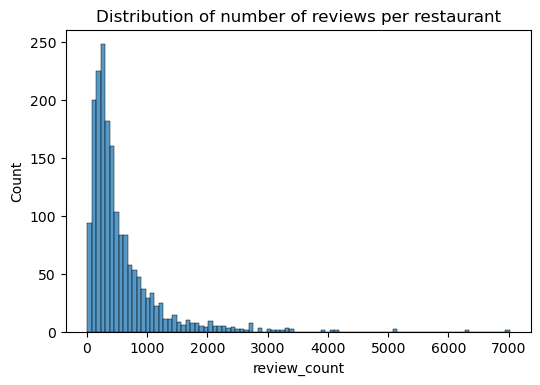

In [ ]:
plt.figure(dpi=100)
ax = sns.histplot(restaurant_breakdown.review_count)
ax.set_title('Distribution of number of reviews per restaurant');

We can see the majority of restaurants receive between 0-1000 reviews, with the mean being 545, and that the distribution is right-skewed.

### Which restaurants are the most/least popular?

We can take an average of the review ratings to obtain lists of the most popular and least popular restaurants.

#### Most Highly Rated Restaurants on Average

In [180]:
restaurant_breakdown.sort_values(by='avg_rating_review', ascending=False).head(10)

,review_count,avg_rating_review
restaurant_name,,
Merlot_Garden_Bar_Restaurant,5,5.000000
Dera,1,5.000000
Pasta_Plant,31,5.000000
Sweetsmile_Bakery_Patisserie,8,5.000000
Leafy_Bean_Co,58,4.982759
The_waves_seafood_grill,50,4.980000
Nora_Cafe,42,4.976190
Tea_Darling_Refreshingly_Vintage,61,4.967213
Little_Brazil_Bar_Restaurant_Ltd,56,4.964286


#### Most Lowly Rated Restaurants on Average

In [151]:
restaurant_breakdown.sort_values(by='avg_rating_review', ascending=True).head(10)

,review_count,avg_rating_review
restaurant_name,,
London_Secret_Garden,34,3.294118
Chotto_Matte,5,3.400000
Viet_Grill,268,3.466418
VyTA_Covent_Garden,59,3.491525
Kanada_Ya_Upper_Street,54,3.537037
Le_Vacherin,10,3.600000
Granaio,328,3.625000
Cay_Tre,593,3.630691
Souk,1362,3.664464


We can also analyse the language used on a per-restaurant-basis. 

## Reviewers

### Who is writing the reviews?

In [132]:
user_breakdown = df.groupby('author_id').agg({'review_id':['count'],
                                      'date':['min','max'],
                                      'rating_review':['mean']})

#### Most Active Reviewers

In [136]:
user_breakdown.sort_values(by=('review_id', 'count'), ascending=False).head(10)

review_id       date            rating_review
              count        min        max          mean
author_id                                              
UID_3787        368 2010-10-10 2020-08-08      4.263587
UID_4000        362 2009-08-08 2020-10-21      4.411602
UID_1408        353 2011-07-27 2020-10-10      4.291785
UID_11357       340 2014-03-02 2020-10-26      4.420588
UID_2606        320 2011-07-08 2020-10-02      4.346875
UID_6388        297 2008-12-07 2020-09-09      4.218855
UID_2385        286 2010-04-14 2020-10-27      4.363636
UID_1594        285 2011-09-26 2020-09-09      4.280702
UID_915         283 2010-10-13 2020-09-23      4.339223
UID_4236        271 2010-11-18 2020-09-26      4.391144

The most active reviewers generally have written reviews over large time-frames (~10 years +), and look to have had fairly positive dining experiences with average ratings of 4.2-4.3

### How many reviews does the average user give?

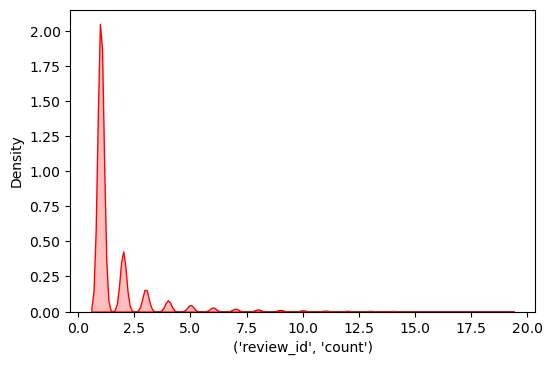

In [183]:
plt.figure(dpi=100)
ax = sns.kdeplot(user_breakdown[user_breakdown.review_id['count']<20][('review_id','count')],shade=True,color='r')

The above visual has been capped to remove users giving more than 20 reviews (which are sparse anyway). We can see that the large majority of users only give one review.